In [1]:
from tifffile import imread
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from pathlib import Path
import napari
import matplotlib.pyplot as plt

In [2]:
DATA_PATH = Path.home() / "Desktop/Code/CELLSEG_BENCHMARK/classifier_test/train"
images_p = list(DATA_PATH.glob("*.tif, *.tiff"))
images_p.sort()
print(f"Loaded {len(images_p)} images")
images = [imread(str(image)) for image in images_p]

DATA_DF_PATH = DATA_PATH / "train_data_df.csv"

Loaded 162 images


In [3]:
if not DATA_DF_PATH.exists():
    data_df = pd.DataFrame([i.name[:-4] for i in images_p], columns=["image_path"])
    # add 100 bins of the hist of each image
    hists = []
    for i, image in enumerate(images):
        # hists.append(np.histogram(image, bins=100)[0])
        hist = np.histogram(image, bins=100)[0]
        hist = hist / hist.sum()
        hists.append(hist)
        
    data_df = pd.concat([data_df, pd.DataFrame(hists)], axis=1)
else:
    data_df = pd.read_csv(DATA_DF_PATH)
    # make the hist a density
    # data_df.iloc[:, 1:-1] = data_df.iloc[:, 1:-1].div(data_df.iloc[:, 1:-1].sum(axis=1), axis=0)
    # make the hist a percentage
    # data_df.iloc[:, 1:-1] = data_df.iloc[:, 1:-1] / 1000
data_df.head()

,image_path,0,1,2,3,4,5,6,7,8,...,91,92,93,94,95,96,97,98,99,label
0,pred_1_SwinUNetR_fragmented_0,0.000004,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000004,0.000008,...,0.004108,0.004677,0.005131,0.004162,0.002697,0.001511,0.000313,0.000027,0.000019,1
1,pred_1_SwinUNetR_fragmented_1,0.000004,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000004,0.000000,...,0.002701,0.002167,0.001957,0.002281,0.001797,0.001286,0.000664,0.000019,0.000015,1
2,pred_1_SwinUNetR_fragmented_10,0.000004,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.009739,0.008644,0.004478,0.003887,0.002670,0.000980,0.000137,0.000103,0.000137,1
3,pred_1_SwinUNetR_fragmented_11,0.000015,0.00005,0.000031,0.000057,0.000042,0.000019,0.000011,0.000019,0.000011,...,0.004078,0.005714,0.007359,0.005615,0.001610,0.000328,0.000080,0.000103,0.000065,1
4,pred_1_SwinUNetR_fragmented_12,0.000004,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.009739,0.008644,0.004478,0.003887,0.002670,0.000980,0.000137,0.000103,0.000137,1


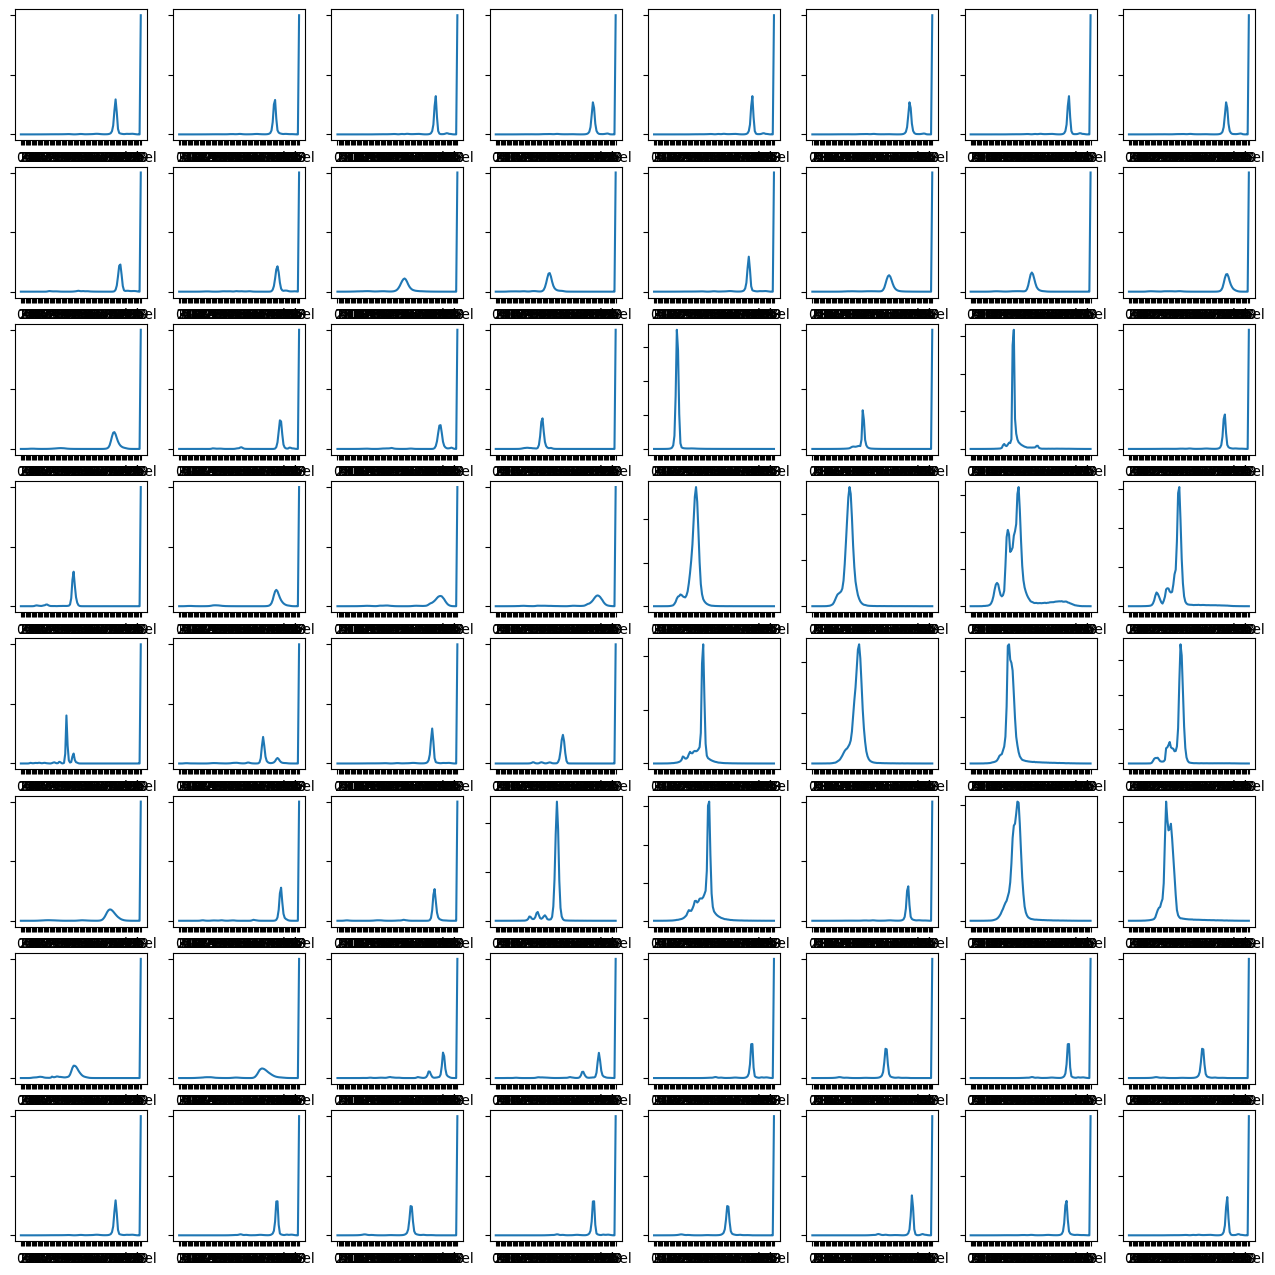

In [4]:
# # plot all histograms
# fig, axs = plt.subplots(8, 8, figsize=(16, 16))
# for i, ax in enumerate(axs.flatten()):
#     ax.plot(data_df.iloc[i, 1:])
#     ax.set_yticklabels([])

In [5]:
from napari.settings import get_settings
settings = get_settings()
settings.application.ipy_interactive = False

# labels = []

# for i, im in enumerate(images):
#     viewer = napari.Viewer()
    
#     @viewer.bind_key("o")
#     def next_label(event):
#         if len(labels) == i+1:
#             print("You have labeled all images already!")
#             return
#         labels.append(0)
#         print("Added label 0")
        
#     @viewer.bind_key("p")
#     def next_label(event):
#         if len(labels) == i+1:
#             print("You have labeled all images already!")
#             return
#         labels.append(1)
#         print("Added label 1")
        
#     @viewer.bind_key("q")
#     def next_label(event):
#         if len(labels) != i+1:
#             print("You need to label the current image first!")
#             return
#         else:
#             viewer.close()
#     @viewer.bind_key("u")
#     def undo_label(event):
#         labels.pop()
#         print("Removed last label")
#         print(labels)
    
#     print(f"Image {i+1}/{len(images)} :")
#     viewer.add_image(im, colormap="turbo")
#     viewer.dims.ndisplay = 3
#     napari.run()

# data_df["label"] = labels
# # save data_df as csv
# data_df.to_csv(DATA_PATH / "train_data_df.csv", index=False)
# display(data_df)

In [6]:
classifier = RandomForestClassifier()
classifier.fit(data_df.iloc[:, 1:-1].values, data_df["label"].values)

RandomForestClassifier()

In [7]:
# test performance on training data
classifier.score(data_df.iloc[:, 1:-1].values, data_df["label"].values)

1.0

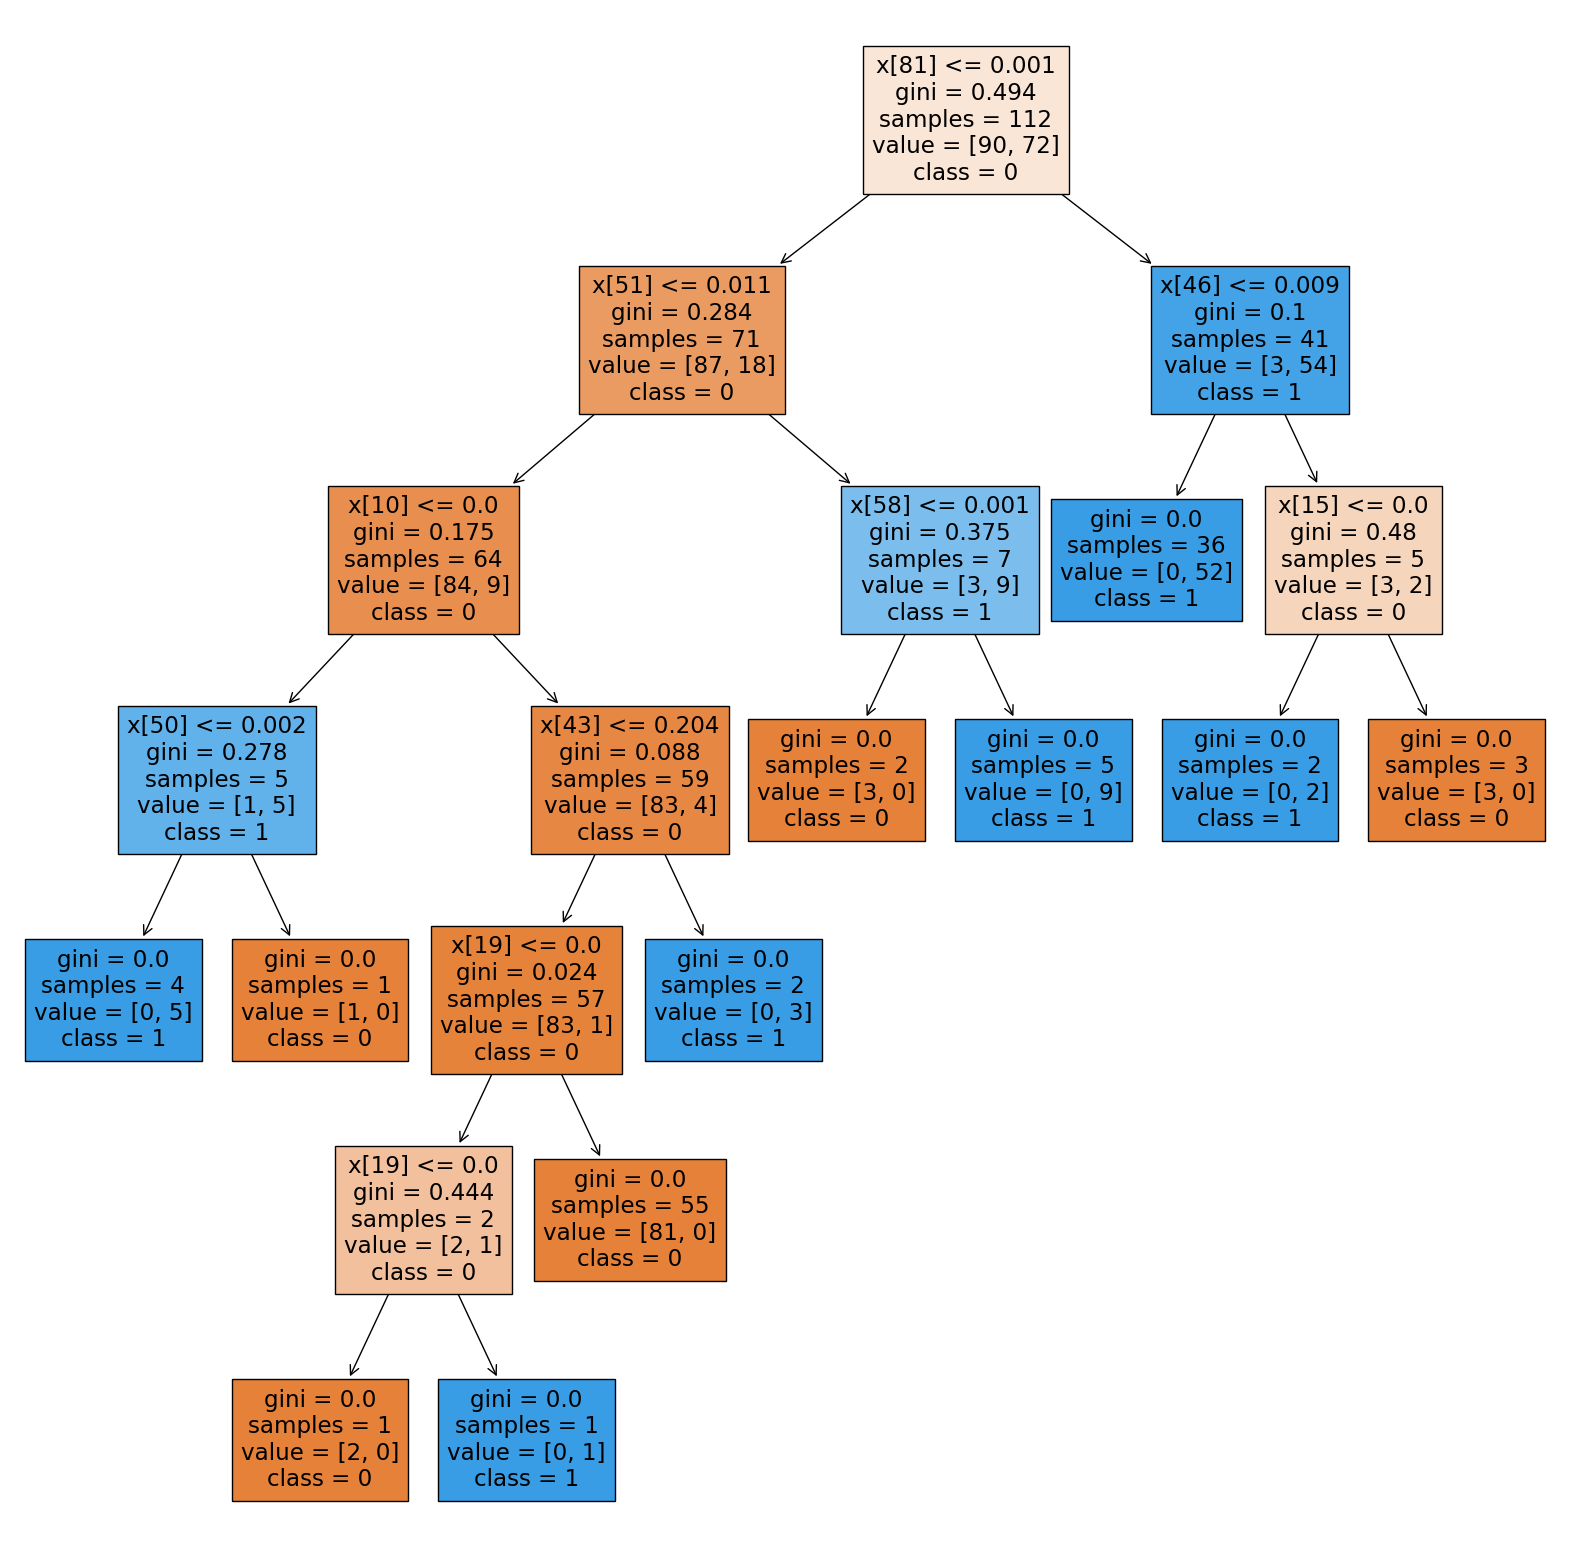

In [8]:
# plot decision tree
from sklearn import tree
plt.figure(figsize=(20, 20))
tree.plot_tree(classifier.estimators_[5], filled=True,class_names=["0", "1"])
plt.show()

In [9]:
# TEST_CROPS_PATH = Path.home() / "Desktop/Code/CELLSEG_BENCHMARK/classifier_test/test_crops_128"
# test_images_p = list(TEST_CROPS_PATH.glob("*.tif"))
# test_images_p.sort()
# print(f"Loaded {len(test_images_p)} images")

# test_images = [imread(str(image)) for image in test_images_p]

# for i, im in enumerate(test_images):
#     # norm_im = (im - im.min()) / (im.max() - im.min())
#     hist = np.histogram(im, bins=100)[0]
#     hist = hist / hist.sum()
#     pred = classifier.predict(hist.reshape(1, -1))
#     print(f"Image {i} is {pred}")
#     # view = napari.view_image(im,colormap="turbo")
#     # view.dims.ndisplay = 3
#     # napari.run()

In [10]:
# TEST_CROPS_PATH = Path.home() / "Desktop/Code/CELLSEG_BENCHMARK/classifier_test/crops_64"
# test_images_p = list(TEST_CROPS_PATH.glob("*.tif"))
# test_images_p.sort()
# print(f"Loaded {len(test_images_p)} images")

# test_images = [imread(str(image)) for image in test_images_p]

# for i, im in enumerate(test_images):
#     # norm_im = (im - im.min()) / (im.max() - im.min())
#     hist = np.histogram(im, bins=100)[0]
#     hist = hist / hist.sum()
#     pred = classifier.predict(hist.reshape(1, -1))
#     print(f"Image {i} is {pred}")
#     # view = napari.view_image(im,colormap="turbo")
#     # view.dims.ndisplay = 3
#     # napari.run()

In [11]:
TEST_DATA_PATH = Path.home() / "Desktop/Code/CELLSEG_BENCHMARK/classifier_test/TEST/TEST_preds_128_overlap_0.tif"
test_image = imread(str(TEST_DATA_PATH))
test_image = test_image.swapaxes(0, 2)

In [12]:
cube_size = 128
preds = np.zeros(test_image.shape)
rejected = np.zeros(test_image.shape)

for i in range(0, test_image.shape[0], cube_size):
    for j in range(0, test_image.shape[1], cube_size):
        for k in range(0, test_image.shape[2], cube_size):
            if i + cube_size >= test_image.shape[0]:
                    crop_location_i = test_image.shape[0] - cube_size
            else:
                crop_location_i = i
            if j + cube_size >= test_image.shape[1]:
                crop_location_j = test_image.shape[1] - cube_size
            else:
                crop_location_j = j
            if k + cube_size >= test_image.shape[2]:
                crop_location_k = test_image.shape[2] - cube_size
            else:
                crop_location_k = k
                
            crop = test_image[crop_location_i:crop_location_i+cube_size, crop_location_j:crop_location_j+cube_size, crop_location_k:crop_location_k+cube_size]
            # crop_normalized = (crop - crop.min()) / (crop.max() - crop.min())
            hist = np.histogram(crop, bins=100)[0]
            hist = hist / hist.sum()
            pred = classifier.predict(hist.reshape(1, -1))[0]
            
            if pred == 0:
                preds[crop_location_i:crop_location_i+cube_size, crop_location_j:crop_location_j+cube_size, crop_location_k:crop_location_k+cube_size] = crop
                rejected[crop_location_i:crop_location_i+cube_size, crop_location_j:crop_location_j+cube_size, crop_location_k:crop_location_k+cube_size] = 0
            else:
                preds[crop_location_i:crop_location_i+cube_size, crop_location_j:crop_location_j+cube_size, crop_location_k:crop_location_k+cube_size] = 0
                rejected[crop_location_i:crop_location_i+cube_size, crop_location_j:crop_location_j+cube_size, crop_location_k:crop_location_k+cube_size] = crop

view = napari.view_image(preds, colormap="turbo")
view.add_image(test_image, colormap="turbo", blending="additive")
view.add_image(rejected, colormap="turbo", blending="additive")
view.grid.enabled = True
view.dims.ndisplay = 3
napari.run()

KeyboardInterrupt: 

In [ ]:
import joblib
joblib.dump(classifier, DATA_PATH / "classifier_new.joblib")

['C:\\Users\\Cyril\\Desktop\\Code\\CELLSEG_BENCHMARK\\classifier_test\\train\\classifier_new.joblib']